In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import nltk
from nltk.stem import WordNetLemmatizer

from tqdm import tqdm
import json

import shutil
import glob
import re

nltk.download('punkt')
nltk.download('wordnet')
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

shutil.copytree('/content/drive/MyDrive/DIP_Project/', '/content/DIP_Project')

Mounted at /content/drive


'/content/DIP_Project'

## Filter unique
- Preprocess: lemmatize + remove fullstop
- filter out english with duplicated translation


In [ ]:
unique_goods = pd.read_csv('/content/DIP_Project/Data/unique_goods.csv')
print(unique_goods.shape)
unique_goods.head()

(291163, 3)


,NAME,ENG,THA
0,37,repair of material and sport equipment,การซ่อมแซมวัสดุและอุปกรณ์กีฬา
1,11,electric coffee machine,เครื่องชงกาแฟไฟฟ้า
2,25,three piece suit [ clothing ],ชุดสูทสามชิ้น [เสื้อผ้า]
3,9,"computer software for obtaining , arranging an...",ซอฟต์แวร์คอมพิวเตอร์สำหรับการรับจัดและจองบริกา...
4,37,service related to exploitation and production...,บริการที่เกี่ยวข้องกับการแสวงประโยชน์และการผลิ...


In [ ]:
def lemmatize_text(text):
    lemmatizer = WordNetLemmatizer()
    word_list = nltk.word_tokenize(text)
    lemmatized = ' '.join([lemmatizer.lemmatize(w) for w in word_list])
    return lemmatized

def process_english(text):
    text = text.strip()
    text = text[:-1] if text.endswith('.') else text
    text = lemmatize_text(text)
    return text

unique_goods['ENG'] = unique_goods['ENG'].apply(process_english)
unique_goods.head()

,NAME,ENG,THA
0,37,repair of material and sport equipment,การซ่อมแซมวัสดุและอุปกรณ์กีฬา
1,11,electric coffee machine,เครื่องชงกาแฟไฟฟ้า
2,25,three piece suit [ clothing ],ชุดสูทสามชิ้น [เสื้อผ้า]
3,9,"computer software for obtaining , arranging an...",ซอฟต์แวร์คอมพิวเตอร์สำหรับการรับจัดและจองบริกา...
4,37,service related to exploitation and production...,บริการที่เกี่ยวข้องกับการแสวงประโยชน์และการผลิ...


In [ ]:
filter_df = unique_goods.groupby('ENG').agg({'THA': list, 'NAME': 'unique'}).reset_index()
filter_df['LEN'] = filter_df['THA'].apply(len)

duplicate_trans = filter_df[filter_df['LEN'] > 1].reset_index(drop=True)
print(duplicate_trans.shape)
duplicate_trans.head()

(47079, 4)


,ENG,THA,NAME,LEN
0,( all aforementioned good included in this cla...,[สินค้าทั้งหมดที่กล่าวมาข้างต้นรวมอยู่ในจำพวกน...,"[4, 1]",2
1,( wireless ) apparatus for communication with ...,[เครื่องมือสำหรับการติดต่อสื่อสารกับเครือข่าย(...,[9],2
2,3-in-1 hair shampoo,[แชมพู 3 ใน 1 เดียว เป็นทั้งแชมพู สบู่เหลวอาบน...,[3],3
3,3D computer graphic software,"[ซอฟต์แวร์กราฟิกคอมพิวเตอร์ 3 มิติ, ซอฟต์แวร์ค...",[9],2
4,3D eye glass,"[แว่นตาสามมิติ, แว่นสามมิติ]",[9],2


## Extract JSON

In [ ]:
def extract_json_pattern(text):
    text = text.split('</think>')[-1]
    pattern = r'''{\s*\"english_source\":\s*\".*?\",\s*\"selected_thai_translation\":\s*\".*?\"\s*}'''
    matches = re.findall(pattern, text, re.DOTALL)

    if matches:
        try:
            return json.loads(matches[0])
        except json.JSONDecodeError as e:
            return {"english_source": np.nan, "selected_thai_translation": np.nan}
    else:
        return {"english_source": np.nan, "selected_thai_translation": np.nan}

def get_answer(path):
    df = pd.read_csv(path).fillna("")
    df['extracted'] = df['ANS'].apply(lambda x: extract_json_pattern(x))

    format_df = pd.DataFrame(df['extracted'].tolist())
    format_df.rename(columns={'english_source': "ENG", "selected_thai_translation": "THA"}, inplace=True)

    return format_df


gemma3_answer = get_answer('/content/DIP_Project/gemma3-27b-it.csv')
qwen3_answer = get_answer('/content/DIP_Project/qwen3-32b-it.csv')

gemma3_answer['qwen3'] = qwen3_answer['THA']
gemma3_answer.head()

,ENG,THA,qwen3
0,( all aforementioned good included in this cla...,สินค้าทั้งหมดที่กล่าวมาข้างต้นรวมอยู่ในจำพวกนี้,สินค้าทั้งหมดที่กล่าวมาข้างต้นรวมอยู่ในจำพวกนี้
1,( wireless ) apparatus for communication with ...,อุปกรณ์สำหรับการสื่อสารกับเครือข่าย(ไร้สาย),อุปกรณ์สำหรับการสื่อสารกับเครือข่าย(ไร้สาย)
2,3-in-1 hair shampoo,แชมพู 3 ใน 1 เดียว เป็นทั้งแชมพู สบู่เหลวอาบน้...,แชมพูสระผมแบบรวมคุณภาพครบถ้วน 3 อย่างในขวดเดียว
3,3D computer graphic software,ซอฟต์แวร์กราฟิกคอมพิวเตอร์ 3 มิติ,ซอฟต์แวร์กราฟิกคอมพิวเตอร์ 3 มิติ
4,3D eye glass,แว่นตาสามมิติ,แว่นตาสามมิติ


In [ ]:
def check_bracket_consistency(eng_text, tha_text):
    eng_brackets = re.findall(r'[^a-zA-Z]', eng_text)
    tha_brackets = re.findall(r'[^\u0E00-\u0E7F]', tha_text)

    eng_brackets = len([x for x in eng_brackets if not x.isspace()])
    tha_brackets = len([x for x in tha_brackets if not x.isspace()])

    return eng_brackets == tha_brackets

gemma3_check = gemma3_answer.fillna("").apply(lambda row: check_bracket_consistency(row['ENG'], row['THA']), axis=1)
qwen3_check = gemma3_answer.fillna("").apply(lambda row: check_bracket_consistency(row['ENG'], row['qwen3']), axis=1)

print(f"Gemma3 correct: {gemma3_check.sum()}")
print(f"Qwen3 correct: {qwen3_check.sum()}")

Gemma3 correct: 35602
Qwen3 correct: 34913


**substitute NaN record from gemma3 with qwen3**

In [ ]:
# Check for NaN values in gemma3_answer
nan_rows = gemma3_answer[gemma3_answer['THA'].isnull()]
print(f"Found {len(nan_rows)} rows with NaN values in gemma3_answer. Replacing with qwen3_answer where available.")

for idx in nan_rows.index:
    gemma3_answer.at[idx, 'ENG'] = qwen3_answer.at[idx, 'ENG']
    gemma3_answer.at[idx, 'THA'] = qwen3_answer.at[idx, 'THA']

# Recheck for NaN values after replacement
nan_rows_after = gemma3_answer[gemma3_answer['THA'].isnull()]
if not nan_rows_after.empty:
    print(f"Found {len(nan_rows_after)} rows with NaN values after replacement.")
else:
    print("No NaN values found in gemma3_answer after replacement.")

gemma3_answer.drop(columns=['qwen3'], inplace=True)

Found 196 rows with NaN values in gemma3_answer. Replacing with qwen3_answer where available.
Found 196 rows with NaN values after replacement.


**Final Result**

In [ ]:
gemma3_answer['NAME'] = duplicate_trans['NAME']
gemma3_answer.dropna().reset_index(drop=True)

print(gemma3_answer.shape)
gemma3_answer.to_csv('gemma3_unique-selected.csv', encoding='utf-8-sig', index=False)

(46883, 3)


**Put it back with unique_df**

In [ ]:
one_translate = pd.read_csv('/content/DIP_Project/processed_data/only1_translation.csv')
gemma3_selected = pd.read_csv('/content/DIP_Project/processed_data/gemma3_unique-selected.csv')

unique = pd.concat([one_translate, gemma3_selected], axis=0).dropna().reset_index(drop=True)
unique['NAME'] = unique['NAME'].apply(lambda x: re.findall(r'[0-9]+', x))

(200997, 3)


,ENG,THA,NAME
0,"( Animal ) skin , pelt",หนัง หนังสัตว์,[18]
1,( IaaS ) infrastructure a a service,ให้บริการโครงสร้างพื้นฐานด้านไอที(ไอเอเอเอส),[42]
2,( abrasive preparation ) soap,(สารที่เตรียมขึ้นใช้ขัด)สบู่,[3]
3,( all good of textile ),สินค้าทั้งหมดที่ทำจากสิ่งทอ,[24]
4,( audio-video ) disc,จานวิดีโอเสียง,[9]


In [ ]:
def normalize_spacing(text: str) -> str:
    for open in ['(', '[']:
        text = text.replace(open + ' ', open)
    for close in [')', ']']:
        text = text.replace(' ' + close, close)

    # Handle Thai parentheses and spacing
    text = re.sub(r'(\S)\(', r'\1 (', text)
    text = re.sub(r'\)(\S)', r') \1', text)
    text = re.sub(r'(\S)\[', r'\1 [', text)
    text = re.sub(r'\](\S)', r'] \1', text)

    # unneccesary parenthesis
    pair = [['(', ')'], ['[', ']']]
    for open, close in pair:
        if text.startswith(open) and text.endswith(close) and text.count(open) == 1 and text.count(close) == 1:
            text = text[1:-1]
    return text


unique['ENG'] = unique['ENG'].apply(normalize_spacing)
unique['THA'] = unique['THA'].apply(normalize_spacing)
unique.head()

,ENG,THA,NAME
0,"(Animal) skin , pelt",หนัง หนังสัตว์,[18]
1,(IaaS) infrastructure a a service,ให้บริการโครงสร้างพื้นฐานด้านไอที (ไอเอเอเอส),[42]
2,(abrasive preparation) soap,(สารที่เตรียมขึ้นใช้ขัด) สบู่,[3]
3,all good of textile,สินค้าทั้งหมดที่ทำจากสิ่งทอ,[24]
4,(audio-video) disc,จานวิดีโอเสียง,[9]
...,...,...,...
200992,zirconia,เซอร์โคเนีย,[1]
200993,zirconium,เซอร์โคเนียม,[6]
200994,zither,ซิทเธอร์ [พิณชนิดหนึ่ง],[15]
200995,zoological garden service,บริการสวนสัตว์,[41]


## Formatted df
- gemma3-27b-it inference

In [ ]:
def check_punctuation_consistency(eng_text, tha_text):
    """
    Checks if the number of non-alphanumeric, non-space characters (punctuation)
    is the same in both English and Thai texts.
    """
    eng_punctuation = re.findall(r'[^a-zA-Z\s]', eng_text)
    tha_punctuation = re.findall(r'[^\u0E00-\u0E7F\s]', tha_text)

    return len(eng_punctuation) == len(tha_punctuation)

In [ ]:
# check with ENG and THA
formatted_df = pd.read_csv('/content/DIP_Project/processed_data/unique_formatted.csv')
formatted_df

,ENG,THA,NAME
0,"(Animal) skin , pelt","(สัตว์) หนัง , ขนสัตว์",['18']
1,(IaaS) infrastructure a a service,ให้บริการโครงสร้างพื้นฐานด้านไอที (ไอเอเอเอส),['42']
2,(abrasive preparation) soap,(สารที่เตรียมขึ้นใช้ขัด) สบู่,['3']
3,all good of textile,สินค้าทั้งหมดที่ทำจากสิ่งทอ,['24']
4,(audio-video) disc,(เสียง-วีดีโอ) แผ่นดิสก์,['9']
...,...,...,...
200992,zirconia,เซอร์โคเนีย,['1']
200993,zirconium,เซอร์โคเนียม,['6']
200994,zither,ซิทเธอร์ [พิณชนิดหนึ่ง],['15']
200995,zoological garden service,บริการสวนสัตว์,['41']


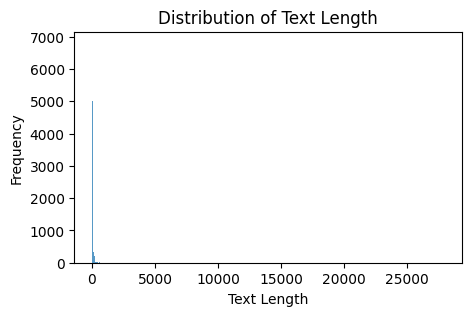

99th percentile len: 412.0


In [ ]:
formatted_df['LEN'] = formatted_df['ENG'].apply(len)

plt.figure(figsize=(5, 3))
sns.histplot(formatted_df['LEN'])
plt.xlabel('Text Length')
plt.ylabel('Frequency')
plt.title('Distribution of Text Length')
plt.show()

print("99th percentile len:", formatted_df['LEN'].quantile(0.99))

In [ ]:
chunk_candidate = formatted_df[formatted_df['LEN'] > 412].reset_index(drop=True)

chunked_data = []
for _, row in chunk_candidate.iterrows():
    if check_punctuation_consistency(row['ENG'], row['THA']):
        if ',' in row['ENG']:
            eng_chunks = row['ENG'].split(',')
            tha_chunks = row['THA'].split(',')
        else:
            eng_chunks = row['ENG'].split('/')
            tha_chunks = row['THA'].split('/')

        if len(eng_chunks) == len(tha_chunks):
            for en, th in zip(eng_chunks, tha_chunks):
                chunked_data.append({
                    'ENG': en.strip(),
                    'THA': th.strip(),
                    'NAME': row['NAME']
                })

chunked_data[:5]

[{'ENG': 'Advisory service relating to security',
  'THA': 'บริการให้คำปรึกษาเกี่ยวข้องกับความปลอดภัย',
  'NAME': "['45']"},
 {'ENG': 'advisory service relating to the security of premise',
  'THA': 'บริการให้คำปรึกษาเกี่ยวข้องกับความปลอดภัยของสถานที่',
  'NAME': "['45']"},
 {'ENG': 'alarm monitoring service',
  'THA': 'บริการตรวจสอบสัญญาณเตือนภัย',
  'NAME': "['45']"},
 {'ENG': 'consultancy service relating to security',
  'THA': 'บริการให้คำปรึกษาเกี่ยวกับความปลอดภัย',
  'NAME': "['45']"},
 {'ENG': 'electronic surveillance',
  'THA': 'เฝ้าระวังทางอิเล็กทรอนิกส์',
  'NAME': "['45']"}]

### Approve chunk

In [ ]:
cleaned_chunk = pd.read_csv('/content/drive/MyDrive/DIP_Project/processed_data/chunk_approved.csv')
cleaned_chunk = cleaned_chunk.drop_duplicates().dropna()

num_only_idx = [1003, 2291, 2292, 2293]
cleaned_chunk = cleaned_chunk.drop(num_only_idx).reset_index(drop=True)
print(cleaned_chunk.shape)
cleaned_chunk.head()

(5414, 3)


,ENG,THA,NAME
0,3D printing on order and according to the requ...,การพิมพ์แบบสามมิติตามคำสั่งและตามข้อกำหนดของบุ...,['40']
1,namely,ได้แก่,['40']
2,machine and machine tool and part thereof,เครื่องจักรและเครื่องมือและชิ้นส่วนของเครื่องจักร,['40']
3,including machine and automated machine tool a...,รวมถึงเครื่องจักรและเครื่องมือและชิ้นส่วนของเค...,['40']
4,part of engine,ชิ้นส่วนของเครื่องยนต์,['40']


**Final unique**

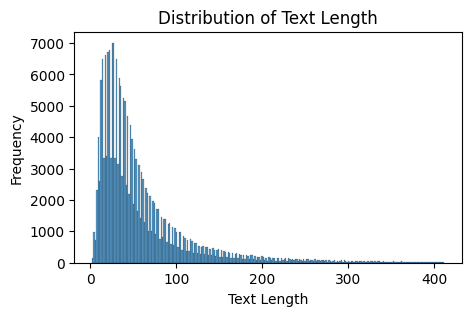

In [ ]:
merge_prep = formatted_df[formatted_df['LEN'] <= 412 ].drop(columns='LEN')
unique_prep = pd.concat([merge_prep, cleaned_chunk], axis=0).reset_index(drop=True)

plt.figure(figsize=(5, 3))
sns.histplot(unique_prep['ENG'].apply(len))
plt.xlabel('Text Length')
plt.ylabel('Frequency')
plt.title('Distribution of Text Length')
plt.show()

In [ ]:
unique_prep.to_csv('/content/drive/MyDrive/DIP_Project/processed_data/unique_prep.csv', index=False, encoding='utf-8-sig')